# Sampling parameters for a compact binary

## Introduction

* This notebook is a tutorial on how to use `ler`'s CBCSourceParameterDistribution module to generate a population of compact binaries coalesence (CBC) with its intrinsic and extrinsic parameters.

* Refer to the [documentation](https://ler.readthedocs.io/en/latest/Unlensed%20events.html) for more details on how CBC parameter priors are used in the calculation of event rates using `ler`.

* Parameters to sampled, $\theta \in$ {$m_1$:mass1, $m_2$:mass2, $D_l$:luminosity-distance, $\iota$:inclination-angle, <br>$\psi$:polarization,
$ra$:right-ascension,$dec$:declination,$\phi_c$:phase-of-coalescene,$t_c$:time-of-coalescene}.

* CBCSourceParameterDistribution class inherits from the SourceGalaxyPopulationModel class. SourceGalaxyPopulationModel is used to sample distributions of CBC's source frame redshifts with provided merger rate density evolution model.

### Default sampling methods for compact binary sources (BBH).

| Parameter | unit | sampling method | range          |
|-----------|------|------------------|----------------|
| $z_s$     | None | merger-rate $R_o^U(z_s)$ | [0,10]         |
| $m_1,m_2$ | $\mathcal{M}_{\odot}$ | PowerLaw+PEAK model | [$m_{\text{min}}$,$m_{\text{max}}$] |
| $ra$      | radian | Uniform | [0,$2\pi$]     |
| $dec$     | radian | cosine | [$-\pi/2$,$\pi/2$] |
| $\iota$   | radian | sine | [0,$\pi$]       |
| $\psi$    | radian | Uniform | [0,$\pi$]      |
| $\phi_c$  | radian | Uniform | [0,$2\pi$]     |
| $t_c$     | sec   | Uniform | [$t_{\text{min}}$,$t_{\text{max}}$] |



In [12]:
from gwcosmo import priors as p
import numpy as np
import matplotlib.pyplot as plt

model = p.BBH_powerlaw_gaussian()

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:162: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:160: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.norm)


Maximum absolute error: 6.918599126937153e-08
Maximum relative error: 1.3372080914955336e-07


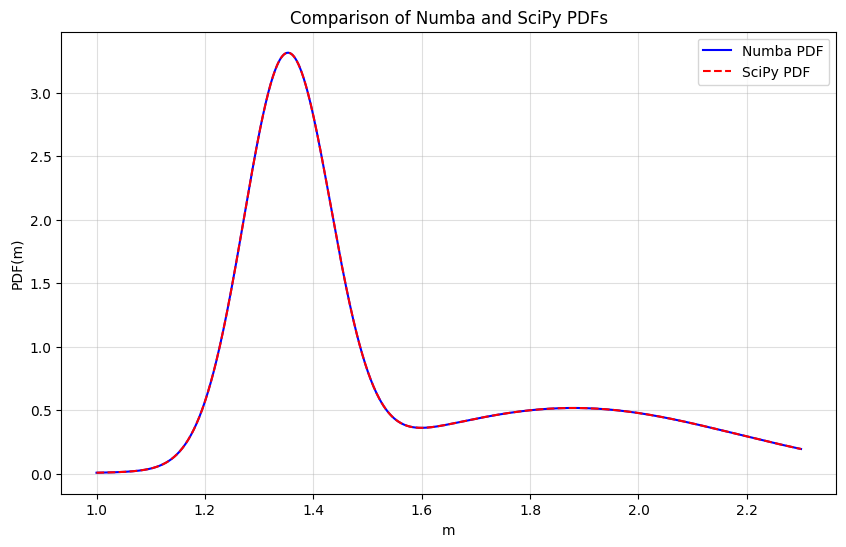

In [20]:
import numpy as np
from scipy.integrate import quad
from scipy.special import erf
from numba import njit

# Numba-compatible erf implementation
@njit
def erf(x):
    # Constants for the approximation
    p = 0.3275911
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.421413741
    a4 = -1.453152027
    a5 = 1.061405429
    
    # Save the sign of x
    sign = np.sign(x)
    x = abs(x)
    
    # A&S formula 7.1.26 given in Handbook of Mathematical Functions
    t = 1.0 / (1.0 + p * x)
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * np.exp(-x * x)
    
    return sign * y

# Numba-compatible normalization factor computation
@njit
def compute_normalization_factor(mu, sigma, mmin, mmax):
    part1 = (mmax - mu) / (np.sqrt(2) * sigma)
    part2 = (mmin - mu) / (np.sqrt(2) * sigma)
    N = np.sqrt(2 * np.pi) * sigma * (0.5 * (erf(part1) - erf(part2)))
    return N

# Numba-compatible PDF computation
@njit
def bns_bimodal_pdf_numpy(m, w=0.643, muL=1.352, sigmaL=0.08, muR=1.88, sigmaR=0.3, mmin=1.0, mmax=2.3):
    # Left peak
    pdf_unnormL = np.exp(-((m - muL) ** 2) / (2 * sigmaL**2))
    normL = compute_normalization_factor(muL, sigmaL, mmin, mmax)
    # Right peak
    pdf_unnormR = np.exp(-((m - muR) ** 2) / (2 * sigmaR**2))
    normR = compute_normalization_factor(muR, sigmaR, mmin, mmax)
    # Total PDF
    pdf = w * pdf_unnormL / normL + (1 - w) * pdf_unnormR / normR
    return pdf

# SciPy-based PDF computation
def bns_bimodal_pdf_scipy(m, w=0.643, muL=1.352, sigmaL=0.08, muR=1.88, sigmaR=0.3, mmin=1.0, mmax=2.3):
    # Left peak
    pdf_unnormL = lambda m: np.exp(-((m - muL) ** 2) / (2 * sigmaL**2))
    normL = quad(pdf_unnormL, mmin, mmax)[0]
    # Right peak
    pdf_unnormR = lambda m: np.exp(-((m - muR) ** 2) / (2 * sigmaR**2))
    normR = quad(pdf_unnormR, mmin, mmax)[0]
    # Total PDF
    pdf = w * pdf_unnormL(m) / normL + (1 - w) * pdf_unnormR(m) / normR
    return pdf

# Test consistency
m_values = np.linspace(1.0, 2.3, 1000)
pdf_numpy = np.array([bns_bimodal_pdf_numpy(m) for m in m_values])
pdf_scipy = np.array([bns_bimodal_pdf_scipy(m) for m in m_values])

# Compare PDF values
absolute_error = np.abs(pdf_numpy - pdf_scipy)
relative_error = absolute_error / np.abs(pdf_scipy)

print("Maximum absolute error:", np.max(absolute_error))
print("Maximum relative error:", np.max(relative_error))

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(m_values, pdf_numpy, label="Numba PDF", linestyle="-", color="blue")
plt.plot(m_values, pdf_scipy, label="SciPy PDF", linestyle="--", color="red")
plt.xlabel("m")
plt.ylabel("PDF(m)")
plt.title("Comparison of Numba and SciPy PDFs")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [22]:
def bns_bimodal_pdf_scipy(m, **kwargs):

    dict_ = {}
    dict_.update(kwargs)

    w = dict_['w']
    muL = dict_['muL']
    sigmaL = dict_['sigmaL']
    muR = dict_['muR']
    sigmaR = dict_['sigmaR']
    mmin = dict_['mmin']
    mmax = dict_['mmax']
    
    # Left peak
    pdf_unnormL = lambda m: np.exp(-((m - muL) ** 2) / (2 * sigmaL**2))
    normL = quad(pdf_unnormL, mmin, mmax)[0]
    # Right peak
    pdf_unnormR = lambda m: np.exp(-((m - muR) ** 2) / (2 * sigmaR**2))
    normR = quad(pdf_unnormR, mmin, mmax)[0]
    # Total PDF
    pdf = w * pdf_unnormL(m) / normL + (1 - w) * pdf_unnormR(m) / normR
    return pdf

In [23]:
dict_ = dict(w=0.643, muL=1.352, sigmaL=0.08, muR=1.88, sigmaR=0.3, mmin=1.0, mmax=2.3)

m_values = np.linspace(1.0, 2.3, 1000)
pdf_numpy = bns_bimodal_pdf_numpy(m_values, **dict_)


In [24]:
pdf_numpy

array([0.00720515, 0.00730963, 0.00741615, 0.0075248 , 0.00763567,
       0.00774882, 0.00786436, 0.00798238, 0.00810298, 0.00822627,
       0.00835236, 0.00848136, 0.0086134 , 0.00874861, 0.00888713,
       0.0090291 , 0.00917467, 0.009324  , 0.00947726, 0.00963463,
       0.00979629, 0.00996244, 0.01013329, 0.01030905, 0.01048994,
       0.01067621, 0.0108681 , 0.01106589, 0.01126984, 0.01148025,
       0.01169742, 0.01192167, 0.01215334, 0.01239277, 0.01264033,
       0.01289642, 0.01316143, 0.01343578, 0.01371993, 0.01401433,
       0.01431947, 0.01463585, 0.01496401, 0.0153045 , 0.01565791,
       0.01602483, 0.0164059 , 0.01680178, 0.01721315, 0.01764075,
       0.01808532, 0.01854763, 0.01902851, 0.0195288 , 0.0200494 ,
       0.02059121, 0.0211552 , 0.02174236, 0.02235373, 0.0229904 ,
       0.02365347, 0.02434412, 0.02506355, 0.02581302, 0.02659383,
       0.02740734, 0.02825493, 0.02913807, 0.03005826, 0.03101706,
       0.03201608, 0.03305699, 0.03414152, 0.03527145, 0.03644

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# calling necessary class from ler package
from ler.gw_source_population import CBCSourceParameterDistribution

In [2]:
# class initialization
cbc = CBCSourceParameterDistribution()

# listing the available priors.
priors = cbc.available_prior_list_and_its_params

# types of priors
print("types of priors=",priors.keys())

# available models of a type
print("models of a type=",priors['source_frame_masses'].keys())

# parameters of a model
print("parameters of a model=",priors['source_frame_masses']['binary_masses_BBH_popI_II_powerlaw_gaussian'])

# default priors
print("default priors=",cbc.gw_param_samplers)

# default priors's parameters
print("default priors's parameters=",cbc.gw_param_samplers_params)

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_0.pickle
differential_comoving_volume interpolator will be generated at ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_6.pickle
merger_rate_density_bbh_popI_II_oguri2018 interpolator will be generated at ./interpolator_pickle/merger_rate_density_bbh_popI_II_oguri2018/merger_rate_density_bbh_popI_II_oguri2018_7.pickle
types of priors= dict_keys(['merger_rate_density', 'source_frame_masses', 'zs', 'spin', 'geocent_time', 'ra', 'phase', 'psi', 'theta_jn'])
models of a type= dict_keys(['binary_masses_BBH_popI_II_powerlaw_gaussian', 'binary_masses_BBH_popIII_lognormal', 'binary_masses_BBH_primordial_lognormal', 'binary_masses_BNS_gwcosmo', 'binary_masses_BNS_bimodal'])
parameters of a model= {'mminbh': 4.98, 'mmaxbh': 112.5, 'alpha': 3.78, 'mu_g': 32.27, 'sigma_g': 3.88, 'lambda_peak': 0.03, 'delta_m': 4.8, 'beta': 0.81}
default p

In [9]:
# available sampler functions (instance attributes)
# the chosen priors will be tied down with the corresponding attribute
# e.g 'binary_masses_BBH_popI_II_powerlaw_gaussian' is the choice then,
# cbc.sample_source_frame_masses will sample from it
# all available sampler attributes are listed below
cbc.sampler_names

{'sample_source_frame_masses': 'samples mass1 and mass2 of the compact binaries',
 'sample_zs': 'samples source redshifts',
 'sample_geocent_time': 'samples geocent_time',
 'sample_ra': 'samples right ascension of sky position',
 'sample_dec': 'samples declination of sky position',
 'sample_phase': 'samples coalescence phase',
 'sample_psi': 'samples polarization angle',
 'sample_theta_jn': 'samples theta_jn'}

## Sampling of parameters

* cbc.sample_gw_parameters method instance sample all the parameters for a compact binary coalescence.

* For sampling single parameter, use the respective method instance. e.g. cbc.binary_masses_BBH_popI_II_powerlaw_gaussian(size=1000)

In [14]:
# It sample all the parameters
params = cbc.sample_gw_parameters(size=10000)
# which parameters are sampled?
print("sampled parameters=",list(params.keys()))

sampled parameters= ['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2']


In [15]:
params['dec']

array([-0.30854608,         nan, -0.72186901, ..., -0.70959012,
               nan,  0.33584625])

In [12]:
# you can put your own sampled parameters
# or you can defined your own sampler which I will show in the next cell
size = 10
params = cbc.sample_gw_parameters(size=size, param=dict(zs=np.linspace(0.1, 1.0, size)))
print(params['zs'])  # all other parameters are sampled from default priors 

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [22]:
# defining your own sampler priors.
# note: the input and output of the function should be the following format
def test_zs(size, param=None):
    """ Test for zs sampler

    Parameters
    ----------
    size: int
        Number of samples to be drawn
    param: None
        dictionary of parameters
        
    Returns
    -------
    zs: array_like
        Redshifts
    """
    zs = np.random.uniform(0.1, 1.0, size=size)
    return zs

# you can put the sampler when you initialize the class
cbc = CBCSourceParameterDistribution(event_priors={'zs': test_zs}, event_priors_params={'zs': None})
params = cbc.sample_gw_parameters(size=10)
print("Sampled redshift values=",params['zs']) 


Sampled redshift values= [0.6651818  0.97285451 0.3135095  0.6759467  0.83463507 0.95009127
 0.26877908 0.63590493 0.40339875 0.8631734 ]


In [23]:
# its the function which was defined in the previous cell
cbc.sample_source_redshifts?

Signature: cbc.sample_source_redshifts(size, param=None)
Docstring:
Test for zs sampler

Parameters
----------
size: int
    Number of samples to be drawn
param: None
    dictionary of parameters
    
Returns
-------
zs: array_like
    Redshifts
File:      /var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_32864/3102535209.py
Type:      function

## Available priors and their comparisions

### Redshift distribution

* For detailed explaination, refer Notebook with title 'Merger rate density model comparision.ipynb'.

### Compact binary mass distribution of BBHs

* Default mass distribution model is `powerlaw with a gaussian peak`. Refer to [WIERDA et al. 2021](https://arxiv.org/pdf/2106.06303.pdf) Appendix B1. for more details.
* This model of BBHs is a statistical model that describes the distribution of primary black hole masses in the BBH population. It consists of two components:
  * **Power-law component**: This component describes the overall trend of the mass distribution, which is that the number of BBHs with a given primary mass decreases as the mass increases.
  * **Gaussian peak component**: This component describes a concentration of BBHs at a particular mass, thought to be due to pulsational pair-instability supernovae (PPISNe).
* The model also includes cut-offs at the minimum and maximum primary black hole masses, which are necessary due to physical limits.

* For secondary mass distribution, the mass ratio is first sampled from a powerlaw distribution and then the secondary mass is calculated from the sampled mass ratio and primary mass.

* `ler` follows the 'BBH_powerlaw_gaussian' class implementation of [gwcosmo](https://lscsoft.docs.ligo.org/gwcosmo/).

* In terms of its fit to the observed data, the POWER-LAW + PEAK model is comparable to other models, such as the broken power law model. However, the POWER-LAW + PEAK model has the advantage of being more physically motivated and more flexible.

Here is a table comparing the POWER-LAW + PEAK model with other models:

| Model                        | Type            | Flexibility | Physical motivation | Fit to data |
| ---------------------------- | --------------- | ------------ | -------------------- | ----------- |
| POWER-LAW + PEAK             | Semi-parametric | High         | Yes                  | Good        |
| Broken power law              | Parametric      | Medium       | No                   | Good        |
| Uniform mass distribution    | Parametric      | Low          | No                   | Poor        |

#### Sampling

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# calling necessary class from ler package
from ler.gw_source_population import CBCSourceParameterDistribution

# initializing the class
cbc = CBCSourceParameterDistribution(event_type="BBH")
# sampling the source frame masses
m1_src, m2_src = cbc.sample_source_frame_masses(size=50000)

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_6.pickle
merger_rate_density_bbh_popI_II_oguri2018 interpolator will be loaded from ./interpolator_pickle/merger_rate_density_bbh_popI_II_oguri2018/merger_rate_density_bbh_popI_II_oguri2018_5.pickle


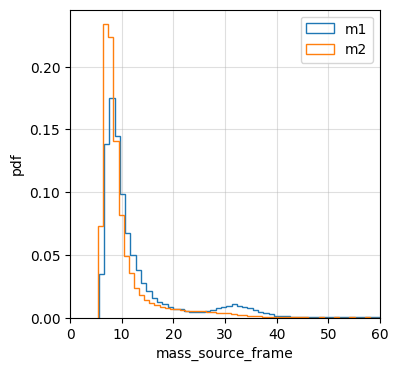

In [7]:
# plot histogram of mass_1_source_frame
plt.figure(figsize=(4,4))
plt.hist(m1_src,bins=100, density=True, histtype='step', label='m1')
plt.hist(m2_src,bins=100, density=True, histtype='step', label='m2')
plt.xlabel('mass_source_frame')
plt.ylabel('pdf')
plt.xlim(0, 60)
plt.grid(alpha=0.4)
plt.legend()
plt.show()

#### comparing two input parameters

* This section explain how to input model parameters.
* It can be at the class initialization stage or at the sampling stage.
* params in [WIERDA et al. 2021](https://arxiv.org/pdf/2106.06303.pdf) vs the default params in [gwcosmo](https://lscsoft.docs.ligo.org/gwcosmo/).

In [29]:
# Wierda et al. 2021
param1 = dict(mminbh=4.98, mmaxbh=86.22, alpha=2.63, mu_g=33.07, sigma_g=5.69, lambda_peak=0.10, delta_m=4.82, beta=1.26)
# gwcosmo
param2 = dict(mminbh=4.98, mmaxbh=86.22, alpha=2.63, mu_g=33.07, sigma_g=5.69, lambda_peak=0.10, delta_m=4.82, beta=1.26)

# if it is in class initialization
# cbc = CBCSourceParameterDistribution(event_priors={'source_frame_masses': cbc.source_frame_masses_powerlaw_gaussian}, event_priors_params={'source_frame_masses': param1})

# sampling
m1_src1, m2_src1 = cbc.sample_source_frame_masses(size=10000, param=param1)
m1_src2, m2_src2 = cbc.sample_source_frame_masses(size=10000, param=param2)

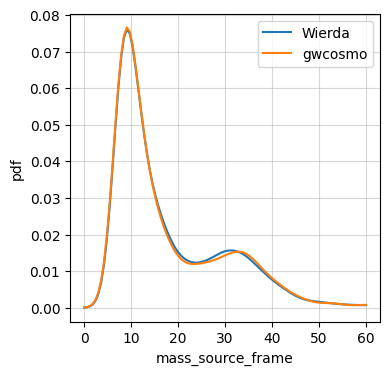

In [32]:
# KDE construction
from scipy.stats import gaussian_kde
kde1 = gaussian_kde(m1_src1)
kde2 = gaussian_kde(m1_src2)

# plot histogram of mass_1_source_frame
plt.figure(figsize=(4,4))
plt.plot(np.linspace(0,60,100), kde1(np.linspace(0,60,100)), label='Wierda')
plt.plot(np.linspace(0,60,100), kde2(np.linspace(0,60,100)), label='gwcosmo')
plt.xlabel('mass_source_frame')
plt.ylabel('pdf')
#plt.xlim(0,60)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

### Compact binary mass distribution of BNS

* The **bimodal mass distribution** of neutron stars in binary systems can be modeled by a double Gaussian distribution, with peaks at around 1.35 M☉ and 1.8 M☉. This model is thought to reflect the different evolutionary paths that neutron stars can take. For more details refer to Refer to [Alsing et al. 2018](https://arxiv.org/pdf/1805.06442.pdf) and Will [M. Farr et al. 2020](https://arxiv.org/pdf/2005.00032.pdf).

\begin{equation}
p(m) = wN (\mu_L, \sigma_L) + (1 − w)N (\mu_R, \sigma_R)
\nonumber
\end{equation}

* $m$: neutron star mass, $w$: fraction of neutron stars in the low-mass peak, $\mu_L$ and $\mu_R$ are the mean masses of the low-mass and high-mass peaks, respectively, $\sigma_L$ and $\sigma_R$ are the standard deviations of the low-mass and high-mass peaks, respectively.

* Neutron stars that form from the collapse of massive stars in binary systems can either remain isolated or undergo mass transfer from their companion stars. Neutron stars that remain isolated have a lower mass distribution, with a peak at around 1.35 M☉. This is because the neutron star will start to collapse if it becomes too massive. Neutron stars that undergo mass transfer from their companion stars can have a higher mass distribution, with a peak at around 1.8 M☉. This is because the neutron star can accrete mass from its companion star until it reaches a maximum mass.

* The parameters of the double Gaussian distribution are as follows:

| Parameter   | Value            |
|-------------|------------------|
| $w$         | 0.643            |
| $\mu_L$     | 1.352 $M_{\odot}$|
| $\sigma_L$  | 0.08 $M_{\odot}$ |
| $\mu_R$     | 1.88 $M_{\odot}$ |
| $\sigma_R$  | 0.3 $M_{\odot}$  |

* Note: each normal distribution is independently truncated and normalized in the range [1, 2.3] $M_{\odot}$. This means that the neutron star masses are not allowed to be less than 1 $M_{\odot}$ or greater than 2.3 $M_{\odot}$.

* This model is a good fit for the observed mass distribution of neutron stars in binary systems.

* Note: Both primary and secondary masses are sampled from the same distribution, but the value is exchanged if the secondary mass is greater than the primary mass.

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_6.pickle
merger_rate_density_bbh_popI_II_oguri2018 interpolator will be loaded from ./interpolator_pickle/merger_rate_density_bbh_popI_II_oguri2018/merger_rate_density_bbh_popI_II_oguri2018_9.pickle
binary_masses_BNS_bimodal interpolator will be loaded from ./interpolator_pickle/binary_masses_BNS_bimodal/binary_masses_BNS_bimodal_0.pickle


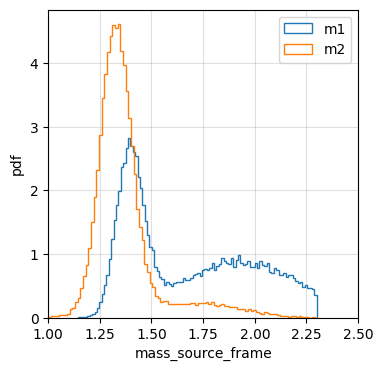

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# calling necessary class from ler package
from ler.gw_source_population import CBCSourceParameterDistribution

# initializing the class
cbc = CBCSourceParameterDistribution(event_type="BNS")

# mass_1_source_frame and mass_2_source_frame
m1_src, m2_src = cbc.sample_source_frame_masses(size=50000)

# plot histogram of mass_1_source_frame, mass_2_source_frame
plt.figure(figsize=(4,4))
plt.hist(m1_src,bins=100, density=True, histtype='step', label='m1')
plt.hist(m2_src,bins=100, density=True, histtype='step', label='m2')
plt.xlabel('mass_source_frame')
plt.ylabel('pdf')
plt.xlim(1,2.5)
plt.grid(alpha=0.4)
plt.legend()
plt.show()


#### Comparing with other BNS models from `gwcosmo`

* `gwcosmo` employs a distribution of the mass with a truncated power law with slope
$-\alpha$ between a minimum mass $m_{min}$ and a maximum mass $m_{max}$. Refer to section 4.2 and eq. A10 in 2111.03604 for more details.

* Note: Both primary and secondary masses are sampled from the same distribution, but the value is exchanged if the secondary mass is greater than the primary mass.

* Diffrent distribution can lead to different event rates. Refer to the notebook 'BNS event rate comparision.ipynb' for more details.

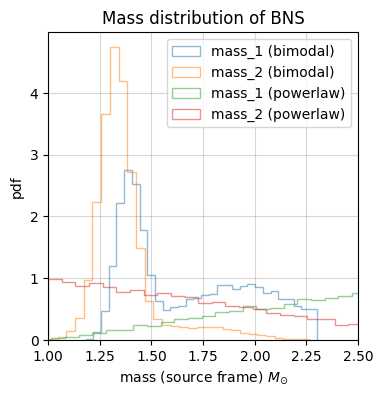

In [22]:
# mass_1_source_frame and mass_2_source_frame
m1_src1, m2_src1 = cbc.binary_masses_BNS_bimodal(size=10000)
m1_src2, m2_src2 = cbc.binary_masses_BNS_popI_II_gwcosmo(size=10000)

# plot histogram of mass_1_source_frame, mass_2_source_frame
plt.figure(figsize=(4,4))
plt.hist(m1_src1,bins=30, density=True, histtype='step', label='m1 (bimodal)', alpha=0.5)
plt.hist(m2_src1,bins=30, density=True, histtype='step', label='m2 (bimodal)', alpha=0.5)
plt.hist(m1_src2,bins=30, density=True, histtype='step', label='m1 (powerlaw)', alpha=0.5)
plt.hist(m2_src2,bins=30, density=True, histtype='step', label='m2 (powerlaw)', alpha=0.5)
plt.xlabel(r'mass (source frame) $M_{\odot}$')
plt.ylabel('pdf')
plt.title('Mass distribution of BNS')
plt.xlim(1,2.5)
plt.grid(alpha=0.5)
plt.legend()
plt.show()


* The power law distribution model is a simpler model than the bimodal distribution model, but it is not as good of a fit to the observed mass distribution of BNS systems. 

* It is important to note that both the bimodal distribution model and the power law distribution model are just models. The true mass distribution of BNS systems may be more complex than either of these models can describe. More data and more sophisticated models are needed to better understand the mass distribution of BNS systems.

### NSBH Binary Mass Distribution: Broken Power-Law Model

The mass distribution of black holes in neutron star-black hole (NSBH) binary systems can be modeled using a broken power-law distribution. This model is characterized by different power-law (PL) slopes for different mass ranges, with a break at a certain mass value. The parameters of the broken power-law model are as follows:

- **mminbh:** Minimum mass of the PL component of the black hole mass distribution.
- **mmaxbh:** Maximum mass of the PL component of the black hole mass distribution.
- **alpha_1:** PL slope of the primary mass distribution for masses below the break mass (mbreak).
- **alpha_2:** PL slope for the primary mass distribution for masses above the break mass (mbreak).
- **b:** The fraction of the way between mminbh and mmaxbh at which the primary mass distribution breaks.
- **delta_m:** Range of mass tapering on the lower end of the mass distribution.
- **beta:** Spectral index for the PL of the mass ratio distribution.

The default values of these parameters are set according to the median values reported in the uniform priors of [LIGO/Virgo Collaboration (arXiv:2111.03604)](https://arxiv.org/pdf/2111.03604.pdf). [LeR](https://ler.readthedocs.io/en/latest/index.html) uses this model through [gwcosmo](https://lscsoft.docs.ligo.org/gwcosmo/).

Here is the default parameters and resultant distribution:

<table>
<tr>
<td>

| Parameter | Default Value |
|-----------|---------------|
| mminbh    | 26            |
| mmaxbh    | 125           |
| alpha_1   | 6.75          |
| alpha_2   | 6.75          |
| b         | 0.5           |
| delta_m   | 5             |
| beta      | 4             |

</td>
<td>

![mass_bns](../../docs/_static/nsbh_mass.png)

</td>
</tr>
</table>

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_6.pickle
merger_rate_density_bbh_popI_II_oguri2018 interpolator will be loaded from ./interpolator_pickle/merger_rate_density_bbh_popI_II_oguri2018/merger_rate_density_bbh_popI_II_oguri2018_8.pickle


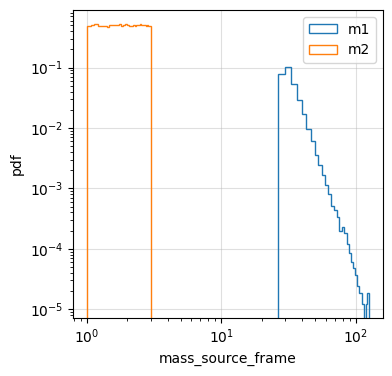

In [11]:
import numpy as np
import matplotlib.pyplot as plt
# calling necessary class from ler package
from ler.gw_source_population import CBCSourceParameterDistribution
# initializing the class
cbc = CBCSourceParameterDistribution(event_type="NSBH")

# mass_1_source_frame and mass_2_source_frame
m1_src, m2_src = cbc.sample_source_frame_masses(size=50000)

# plot histogram of mass_1_source_frame, mass_2_source_frame
plt.figure(figsize=(4,4))
plt.hist(m1_src,bins=30, density=True, histtype='step', label='m1')
plt.hist(m2_src,bins=30, density=True, histtype='step', label='m2')
plt.xlabel('mass_source_frame')
plt.ylabel('pdf')
#plt.xlim(0,60.)
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.4)
plt.legend()
plt.show()

## BBHs mass distribution with different origins (popI/II vs popIII vs primordial black holes)

### Primordial origin

* Take reference to section 2.1 [Ng et al. 2022](https://arxiv.org/pdf/2204.11864.pdf) for more details.

* In BBH primordial mass distribution, black holes form from radiation-induced overdensities in the early Universe.

* They exhibit a Poisson spatial distribution, initiating binary black hole formation at high redshifts due to gravitational attraction.

* The PBH mass distribution follows a lognormal function centered at $M_c$ (not to be confuse with Chirp mass $\mathcal{M}_c$) with width $\sigma$.

\begin{equation}
\psi(m|M_c,\sigma) = \frac{1}{\sqrt{2 \pi} \sigma m} \exp\left(-\frac{\log^2(m/M_c)}{2\sigma^2}\right)
\nonumber
\end{equation}

* Like the method used in [Ng et al. 2022](https://arxiv.org/pdf/2204.11864.pdf), `ler` neglects the role of accretion. This means that the constraints we set on the PBH abundance based on merger rate estimates are the least stringent, and may be translated to smaller values of $f_{PBH}$ (PBH fraction) if a strong accretion phase is assumed.

* Assuming a small enough abundance $f_{PBH}<<10^{−3}$ , one can write the PBH mass function as,

\begin{equation}
p(m_1, m_2) \propto (m_1 + m_2)^{-36/37} (m_1 m_2)^{-32/37} \psi(m_1) \psi(m_2)
\nonumber
\end{equation}

* m1 and m2 will be sampled from the 2D probability distribution function (PDF) with $[m_{min}, m_{max}]\in [1,100]$. Its reasonable to assume the set limits as the fraction of PBHs with masses outside this range is negligible.

* Minimum and maximum mass of PBHs are very uncertain. Ref. [Bernard Carr et al. 2016](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.94.083504).
  * **Minimum Mass**: The lower mass limit for PBHs is set by the Hawking radiation process. Black holes that are too light would have evaporated by now. This limit can be as low as ~10^-18 solar masses or even less, but such extremely light PBHs would have evaporated shortly after their formation.
  * **Maximum Mass**: The upper mass limit for PBHs is constrained by various cosmological observations like the cosmic microwave background radiation and the large-scale structure of the universe. This could be up to several tens or even hundreds of solar masses, though the exact value is constrained by observational limits.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# calling necessary class from ler package
from ler.gw_source_population import CBCSourceParameterDistribution

# initializing the class
cbc = CBCSourceParameterDistribution(event_priors=dict(source_frame_masses= 'binary_masses_BBH_primordial_lognormal'), event_priors_params=dict(source_frame_masses= dict(m_min=1.0, m_max=100.0, Mc=30.0, sigma=0.3)))

In [12]:
# sampling
# PBH
m1_PBH, m2_PBH = cbc.sample_source_frame_masses(size=10000)
# BBH popI/II
m1_BBH, m2_BBH = cbc.binary_masses_BBH_popI_II_powerlaw_gaussian(size=10000)

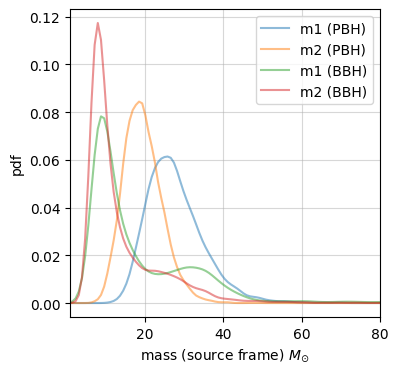

In [14]:
# KDE construction
from scipy.stats import gaussian_kde
kde_m1_PBH = gaussian_kde(m1_PBH)
kde_m2_PBH = gaussian_kde(m2_PBH)
kde_m1_BBH = gaussian_kde(m1_BBH)
kde_m2_BBH = gaussian_kde(m2_BBH)

# plot pdf
plt.figure(figsize=(4,4))
plt.plot(np.linspace(0,80,100), kde_m1_PBH(np.linspace(0,80,100)), label='m1 (PBH)', alpha=0.5)
plt.plot(np.linspace(0,80,100), kde_m2_PBH(np.linspace(0,80,100)), label='m2 (PBH)', alpha=0.5)
plt.plot(np.linspace(0,80,100), kde_m1_BBH(np.linspace(0,80,100)), label='m1 (BBH)', alpha=0.5)
plt.plot(np.linspace(0,80,100), kde_m2_BBH(np.linspace(0,80,100)), label='m2 (BBH)', alpha=0.5)
plt.xlabel(r'mass (source frame) $M_{\odot}$')
plt.ylabel('pdf')
plt.xlim(1,80)
plt.grid(alpha=0.5)
plt.legend()
plt.show()



### Pop III origin

- Refer to [Ng et al.](https://ar5iv.labs.arxiv.org/html/2204.11864) for more details. Note that the mass distribution model and model parameters are same as that of primordial black holes. 

- Pop III binary black holes (BBHs) are expected to have a different mass distribution than BBHs with solar metallicity. This is because Pop III stars are more massive and have shorter lifetimes than solar metallicity stars. As a result, Pop III BBHs are expected to have a higher mass fraction of high-mass black holes.

- **Model Usage:** A phenomenological model is used to estimate the volumetric merger rate density of Pop III BBHs, based on a fit to data from population synthesis studies .

- **Mass Spectrum Uncertainty:** The mass spectrum of Pop III BBHs is highly uncertain due to the initial conditions of Pop III stars, with the paper assuming an identical mass spectrum for Pop III BBHs and Primordial Black Hole mergers.

- **High Redshift Merger Dominance:** Mergers of black holes from Pop III stars, along with primordial black hole mergers, are expected to dominate at high redshifts (z ≳ 10), crucial for gravitational-wave detections.

* Note: If the mass distributions of PBHs and BBHs (popIII) are the same, then we cannot tell them apart based on mass alone. We need to measure redshift to do this. This is a cautious approach, because if their mass is different, then we could use this information to tell them apart and get more accurate measurements.
